# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

## Step 1: Read in Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso
import censusgeocode as cg
import sklearn
import pickle


sns.set(style="darkgrid")

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [3]:
df = pd.read_csv("../provided_data/kc_house_data_train.csv", index_col="Unnamed: 0")

In [4]:
print(df.columns)
ignore_cols = ['id', 'price', 'date']
explore_cols = [x for x in df.columns if x not in ignore_cols]

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [5]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df[explore_cols].values, i) for i in range(df[explore_cols].shape[1])]
vif["features"] = df[explore_cols].columns
vif.round(1)

/Users/browz/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,22.5,bedrooms
1,28.4,bathrooms
2,inf,sqft_living
3,2.3,sqft_lot
4,16.8,floors
5,1.2,waterfront
6,1.6,view
7,34.5,condition
8,147.9,grade
9,inf,sqft_above


In [192]:
# fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16,30))

# for i, column in enumerate(explore_cols):
#     sns.scatterplot(data = df, x=column,y='price', ax=axes[i//3, i%3])

## Step 3: Clean up any issues (extreme values, etc.) with the data.  

Remember that you can't just delete rows with extreme values. Similar observations might be present in the holdout data set, and you can't just delete those rows and not have a prediction for it. 

In [193]:
df['shack_living'] = np.where(df['sqft_living']/df['sqft_lot'] < .2, 1, 0)

In [194]:
# df['bedrooms'].iloc[483] = 4 
# df['bathrooms'].iloc[483] =  2.5
# df['bedrooms'].iloc[1120] = 5
# df['bathrooms'].iloc[1120] =  4
# df['bedrooms'].iloc[3032] = 3
# df['bathrooms'].iloc[3032] = 1.5
# df['bedrooms'].iloc[3609] = 4
# df['bathrooms'].iloc[3609] = 3
# df['bedrooms'].iloc[5424] = 3
# df['bathrooms'].iloc[5424] = 3
# df['bedrooms'].iloc[6409] = 3
# df['bathrooms'].iloc[6409] = 2
# df['bedrooms'].iloc[9286] = 4
# df['bathrooms'].iloc[9286] = 4.5
# df['bedrooms'].iloc[10074] = 4
# df['bathrooms'].iloc[10074] = 2.5
# df['bedrooms'].iloc[15733] = 3
# df['bathrooms'].iloc[15733] = 2.5

# df.drop(index=[9060,12982,13989,10067,2430], inplace=True)

In [195]:
df['bedrooms'] = df['bedrooms'].replace({11:4, 33:3})

In [196]:
# fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16,25))

# for i, column in enumerate(explore_cols):
#     sns.boxplot(data = df, x=column, ax=axes[i//3, i%3])

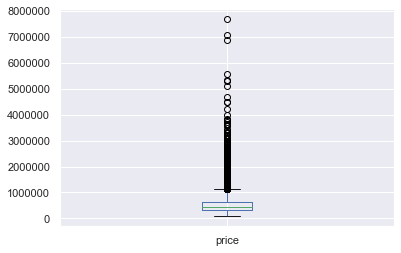

In [197]:
df.price.plot.box()

## Step 4: Generate new features that you think could be important.

After doing this, you will want to go back to steps 2 and 3 to investigate these new features.

In [198]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'shack_living'],
      dtype='object')

In [199]:
def distance_to(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

In [200]:
# amzn_hdqt = (47.623583541669845, -122.33669143795257)
# msft_hdqt = 47.641489, -122.134503

# dist_msft, dist_amzn = [], []
# for row in df.itertuples(index=False):
#     dist_amzn.append(distance_to(row.lat, row.long, amzn_hdqt[0], amzn_hdqt[1]))
#     dist_msft.append(distance_to(row.lat, row.long, msft_hdqt[0], msft_hdqt[1]))
# df['dist_amzn'] = dist_amzn
# df['dist_msft'] = dist_msft

In [201]:
# df['dist_msft'] = np.where(df['dist_msft'] > 10, 0, 1)
# df['dist_amzn'] = np.where(df['dist_amzn'] > 7, 0, 1)



In [202]:
df['yrs_old'] = 2020-df.yr_built

In [203]:
df['age_feature'] = (df['yrs_old'] - 57)**2
df['grade_exp'] = np.exp(df['grade'])

In [204]:
conditions = [df['condition']<= 2, df['condition'].isin(range(3, 5)), df['condition'] == 5]
choices = ['busted', 'aight', 'dope']

df['cond_cat'] = np.select(conditions, choices, default = 'missing')

In [205]:
df['has_basement'] = np.where(df['sqft_basement'] == 0, 0, 1)

In [206]:
df['date'] = pd.to_datetime(df['date'], format="%Y%m%dT000000")
df['season'] = (df.date.dt.month%12 + 3)//3

In [207]:
df['grade_exp'] = np.exp(df['grade'])

### 4.1) Identify a categorical variable in the data set and create dummy columns.

In [208]:
season_dum = pd.get_dummies(df['season'], prefix='sn', drop_first=True)
zipcode_dum = pd.get_dummies(df['zipcode'], prefix='zp', drop_first=True)
cond_dum = pd.get_dummies(df['cond_cat'], prefix='condtn', drop_first=True)
df = pd.concat([df, cond_dum, zipcode_dum, season_dum], 1)

### 4.3) There are columns for when the house was built and when it was renovated.  How could you use these columns to create a new column?

In [209]:
#your code here 
df['last_const'] = np.where(df['yr_renovated']==0, 2020-df['yr_built'],2020-df['yr_renovated'])

### <ins>Non-linear transformations</ins>

### 4.4) Create a polynomial feature for two of your continuous variables.

### 4.5) Create an interaction feature between a binary variable (dummy variable) and a continuous variable.

In [210]:
df.condtn_dope.value_counts()

0    15923
1     1367
Name: condtn_dope, dtype: int64

## Step 5: Train-Test Split

If you plan on doing any scaling of your data, make sure it is done at the appropriate time. 

### 5.1) Perform a train-test split of the data.

In [211]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view',
       ...
       'zp_98168', 'zp_98177', 'zp_98178', 'zp_98188', 'zp_98198', 'zp_98199',
       'sn_2', 'sn_3', 'sn_4', 'last_const'],
      dtype='object', length=103)

In [212]:
leave_out = ['id', 'date', 'season', 'price', 'cond_cat', 'sqft_lot', 
             'floors', 'view', 'condition', 'grade', 'sqft_above', 
             'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 
             'long', 'sqft_living15', 'last_const']
features = [x for x in df.columns if x not in leave_out] 

In [213]:
#your code here 
X_train, X_test, y_train, y_test = train_test_split(df[features], df['price'], random_state=57,test_size=0.2)

print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)

Training set - Features:  (13832, 84) Target:  (13832,)
Training set - Features:  (3458, 84) Target:  (3458,)


### 5.2) Fit your scaler to training the data.

In [214]:
scaler = StandardScaler()

scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

### 5.3) Transform the testing set with the scaler.

In [215]:
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=df[features].columns)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=df[features].columns)

### 5.4) Fit the model to the training data.

In [216]:
lm = LinearRegression()
lm = lm.fit(X_train, y_train)

### 5.5) Use the model to predict on the training set and the test set.

In [217]:
y_train_pred = lm.predict(X_train)

y_test_pred = lm.predict(X_test)

### 5.6) Evaluate the training and test predictions using RMSE.

In [218]:
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

### 5.7) Determine if your model is overfit.

In [219]:
print(f'Training: {int(train_rmse)} vs Testing: {int(test_rmse)}')

Training: 158724 vs Testing: 156594


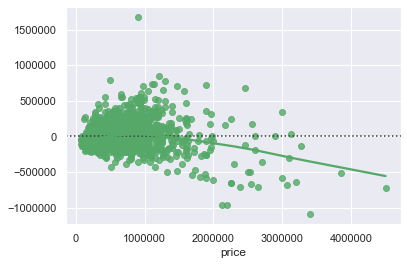

In [220]:
sns.residplot(x = y_test, y= y_test_pred, lowess=True, color = "g")

## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models.

### 6.2) After removing the features, re-run Step 5 and see if your new model performs better than the old model.

In [221]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(df[features])
poly2_columns = poly_2.get_feature_names(df[features].columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)

In [222]:
X_train, X_test, y_train, y_test = train_test_split(df_poly2, df['price'], random_state=27,test_size=0.2)

In [223]:
scaler2 = StandardScaler()

scaler2.fit(X_train)

X_train = pd.DataFrame(data=scaler2.transform(X_train), columns=df_poly2.columns)

X_test = pd.DataFrame(data=scaler2.transform(X_test), columns=df_poly2.columns)

In [224]:
# instantiate a linear regression object
lm_2 = LinearRegression()

#fit the linear regression to the data
lm_2 = lm_2.fit(X_train, y_train)

y_train_pred = lm_2.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

In [225]:
y_pred = lm_2.predict(X_test)

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Training:  112038 vs. Testing:  1139163354488217


In [226]:
bad_ind = abs(y_test-y_pred).sort_values(ascending=False).index
abs(y_test-y_pred).sort_values(ascending=False)

2016     5.968007e+16
17111    1.909613e+16
9217     1.550891e+16
14178    1.550891e+16
5230     8.106454e+15
             ...     
7220     1.200738e+02
17047    1.059262e+02
17244    8.807381e+01
15615    4.407381e+01
14158    3.926194e+00
Name: price, Length: 3458, dtype: float64

In [227]:
df.shack_living.value_counts()

0    10784
1     6506
Name: shack_living, dtype: int64

In [228]:
df.loc[bad_ind][:10]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,shack_living,yrs_old,age_feature,grade_exp,cond_cat,has_basement,season,condtn_busted,condtn_dope,zp_98002,zp_98003,zp_98004,zp_98005,zp_98006,zp_98007,zp_98008,zp_98010,zp_98011,zp_98014,zp_98019,zp_98022,zp_98023,zp_98024,zp_98027,zp_98028,zp_98029,zp_98030,zp_98031,zp_98032,...,zp_98039,zp_98040,zp_98042,zp_98045,zp_98052,zp_98053,zp_98055,zp_98056,zp_98058,zp_98059,zp_98065,zp_98070,zp_98072,zp_98074,zp_98075,zp_98077,zp_98092,zp_98102,zp_98103,zp_98105,zp_98106,zp_98107,zp_98108,zp_98109,zp_98112,zp_98115,zp_98116,zp_98117,zp_98118,zp_98119,zp_98122,zp_98125,zp_98126,zp_98133,zp_98136,zp_98144,zp_98146,zp_98148,zp_98155,zp_98166,zp_98168,zp_98177,zp_98178,zp_98188,zp_98198,zp_98199,sn_2,sn_3,sn_4,last_const
2016,7403200050,2014-11-13,1600000.0,3,2.25,3370,23065,1.0,1,4,3,10,1920,1450,1980,0,98028,47.7434,-122.263,3410,19688,1,40,289,22026.465795,aight,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,40
17111,4045500510,2014-05-21,420850.0,1,1.00,960,40946,1.0,0,0,5,5,960,0,1945,0,98014,47.6951,-121.864,1320,20350,1,75,324,148.413159,dope,0,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,75
9217,3398800055,2014-11-19,2400000.0,4,3.75,4090,24825,2.0,0,0,4,11,3400,690,1926,0,98102,47.6338,-122.319,3910,11500,1,94,1369,59874.141715,aight,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,94
14178,1952200240,2014-06-11,850830.0,3,2.50,2070,13241,1.5,0,0,5,9,1270,800,1910,0,98102,47.6415,-122.315,2200,4500,1,110,2809,8103.083928,dope,1,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,110
5230,5152600090,2014-07-08,235500.0,5,2.50,2340,13713,1.0,0,0,2,8,1670,670,1967,0,98003,47.3307,-122.324,2080,11000,1,53,16,2980.957987,busted,1,3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,53
10067,3980300371,2014-09-26,142000.0,0,0.00,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850,1,57,0,2.718282,busted,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,57
2817,1324079029,2015-03-17,200000.0,3,1.00,960,213008,1.0,0,0,2,6,960,0,1933,0,98024,47.5621,-121.862,1520,57499,1,87,900,403.428793,busted,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,87
11817,6073300040,2015-01-06,375000.0,4,2.25,2020,12500,2.0,0,0,2,8,2020,0,1966,0,98056,47.5403,-122.175,1800,13175,1,54,9,2980.957987,busted,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54
1187,1068000375,2014-09-23,3200000.0,6,5.00,7100,18200,2.5,0,0,3,13,5240,1860,1933,2002,98199,47.6427,-122.408,3130,6477,0,87,900,442413.392009,aight,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,18
4177,7738500731,2014-08-15,4500000.0,5,5.50,6640,40014,2.0,1,4,3,12,6350,290,2004,0,98155,47.7493,-122.280,3030,23408,1,16,1681,162754.791419,aight,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,16


In [229]:
df_poly2.shape

(17290, 3654)

### Feature Selection

### Lasso

In [230]:
lasso = Lasso(alpha=750, normalize=False)

lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

train_rmse_lasso01 = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse_lasso01 = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse_lasso01))
print('Testing Error: '+ str(test_rmse_lasso01))

Training Error: 73147.5428969896
Testing Error: 143087.00311401414


In [231]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=800, normalize=False)

ridge.fit(X_train,y_train)

y_train_pred = ridge.predict(X_train)
y_pred = ridge.predict(X_test)

train_rmse_ridge01 = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse_ridge01 = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse_ridge01))
print('Testing Error: '+ str(test_rmse_ridge01))
ridge.coef_

Training Error: 72002.697244761
Testing Error: 149791.59116858296


array([ 5005.22227236, 10981.48180155, 54695.60201223, ...,
       -2832.34306381,     0.        , -5717.07351909])

## Step 7: Evaluate your different models in order to determine the best model overall.

## Step 8:  Refit your best model to the entire dataset.

In [232]:
final_scaler = StandardScaler()

df_final_scaled = pd.DataFrame(data=final_scaler.fit_transform(df_poly2), columns=poly2_columns)

In [233]:
lasso_final = Lasso(alpha=750, normalize=False)

lasso_final.fit(df_final_scaled, df['price'])

Lasso(alpha=750, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

## Step 9: Save your final model using pickle.

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [234]:
pickle_out = open("pickle_jar/model.pkl", "wb")
pickle.dump(lasso_final, pickle_out)
pickle_out.close()

In [235]:
pickle_out = open("pickle_jar/scaler.pkl", "wb")
pickle.dump(final_scaler, pickle_out)
pickle_out.close()

In [237]:
df_poly2.shape

(17290, 3654)